In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the datasets
df_train = pd.read_csv('D:/week4 data/train.csv', low_memory=False)
df_store = pd.read_csv('D:/week4 data/store.csv', low_memory=False)

# Merge the datasets on the 'Store' column
df_merged = pd.merge(df_train, df_store, on='Store')

# Convert 'Date' column to datetime
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Handle NaN values for numeric columns
numeric_cols = df_merged.select_dtypes(include=['number']).columns
df_merged[numeric_cols] = df_merged[numeric_cols].fillna(df_merged[numeric_cols].mean())

# Extract new features from 'Date' column
df_merged['Weekday'] = df_merged['Date'].dt.weekday
df_merged['Is_Weekend'] = df_merged['Weekday'] >= 5
df_merged['Month'] = df_merged['Date'].dt.month
df_merged['Year'] = df_merged['Date'].dt.year

# Define holidays (Example dates for Christmas and New Year)
holidays = pd.to_datetime(['2013-12-25', '2014-12-25', '2015-12-25', '2014-01-01', '2015-01-01'])

# Calculate number of days to the next holiday
df_merged['Days_to_Holiday'] = df_merged['Date'].apply(lambda x: (holidays - x).min().days)

# Calculate number of days after the last holiday
df_merged['Days_After_Holiday'] = df_merged['Date'].apply(lambda x: (x - holidays[holidays <= x].max()).days)

# Identify the beginning, mid, and end of the month
df_merged['Month_Period'] = pd.cut(df_merged['Date'].dt.day, bins=[0, 10, 20, 31], labels=['Beginning', 'Mid', 'End'])

# Convert categorical columns to numeric using one-hot encoding
df_merged = pd.get_dummies(df_merged, columns=['Month_Period', 'StoreType', 'Assortment'], drop_first=True)

# Select features for scaling
features_to_scale = df_merged[['Sales', 'Customers', 'CompetitionDistance', 'Days_to_Holiday', 'Days_After_Holiday']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the data
scaled_features = scaler.fit_transform(features_to_scale)

# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Combine scaled features with the rest of the dataset
df_preprocessed = df_merged.drop(columns=features_to_scale.columns).reset_index(drop=True)
df_preprocessed = pd.concat([df_preprocessed, scaled_df], axis=1)

print("Preprocessed Data:")
print(df_preprocessed.head())

# Save the preprocessed data to a CSV file
df_preprocessed.to_csv('D:/week4 data/preprocessed_data.csv', index=False)




Preprocessed Data:
   Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday  \
0      1          5 2015-07-31     1      1            0              1   
1      2          5 2015-07-31     1      1            0              1   
2      3          5 2015-07-31     1      1            0              1   
3      4          5 2015-07-31     1      1            0              1   
4      5          5 2015-07-31     1      1            0              1   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  ...  \
0                        9.0                    2008.0       0  ...   
1                       11.0                    2007.0       1  ...   
2                       12.0                    2006.0       1  ...   
3                        9.0                    2009.0       0  ...   
4                        4.0                    2015.0       0  ...   

   StoreType_b  StoreType_c StoreType_d  Assortment_b  Assortment_c     Sales  \
0        False        

C:\Users\Robel\AppData\Local\Temp\ipykernel_17900\2667677.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_preprocessed = pd.read_csv('D:/week4 data/preprocessed_data.csv')


Model saved successfully!
Mean Squared Error: 0.01345760240444456
R^2 Score: 0.9865122581095852


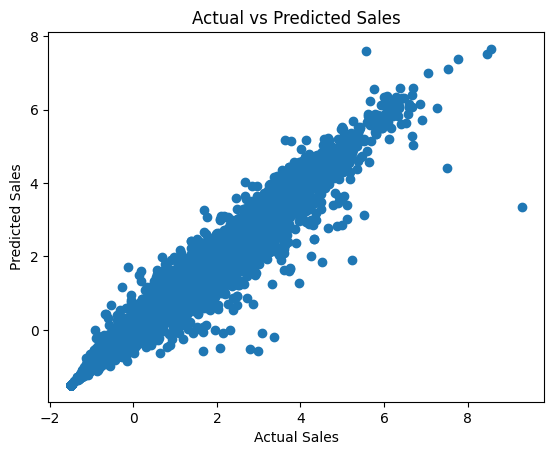

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Load the preprocessed data
df_preprocessed = pd.read_csv('D:/week4 data/preprocessed_data.csv')

# Drop non-numeric columns
df_preprocessed = df_preprocessed.drop(columns=['Date', 'StateHoliday', 'PromoInterval'])

# Define features and target variable
X = df_preprocessed.drop(columns=['Sales'])
y = df_preprocessed['Sales']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])

# Train the model
pipeline.fit(X_train, y_train)

# Save the model to a file
joblib.dump(pipeline, 'D:/week4 data/random_forest_pipeline.pkl')
print("Model saved successfully!")

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Visualize the results (Optional)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()


C:\Users\Robel\AppData\Local\Temp\ipykernel_17900\1735671570.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_preprocessed = pd.read_csv('D:/week4 data/preprocessed_data.csv')


Model saved successfully!
Mean Absolute Error: 0.0693103521899023


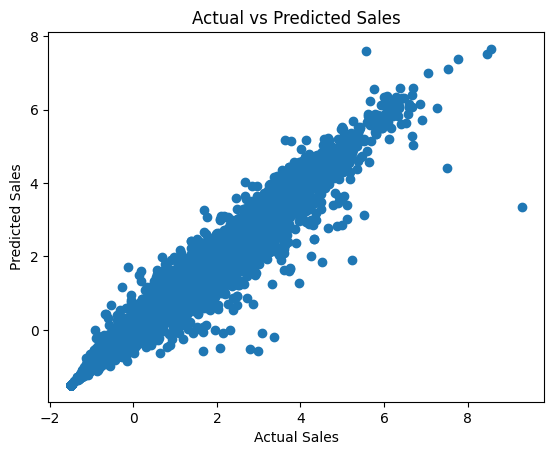

In [3]:
from sklearn.metrics import mean_absolute_error

# Load the preprocessed data
df_preprocessed = pd.read_csv('D:/week4 data/preprocessed_data.csv')
df_preprocessed = df_preprocessed.drop(columns=['Date', 'StateHoliday', 'PromoInterval'])

# Define features and target variable
X = df_preprocessed.drop(columns=['Sales'])
y = df_preprocessed['Sales']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])

# Train the model
pipeline.fit(X_train, y_train)

# Save the model to a file
joblib.dump(pipeline, 'D:/week4 data/random_forest_pipeline.pkl')
print("Model saved successfully!")

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model using MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Visualize the results (Optional)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()